In [1]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from mhealth_anomaly_detection import anomaly_detection
from mhealth_anomaly_detection import format_axis as fa
from mhealth_anomaly_detection import load_refs as lr
importlib.reload(anomaly_detection)

/Users/sakre/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'mhealth_anomaly_detection.anomaly_detection' from '/Users/sakre/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/anomaly_detection.py'>

In [3]:
# Load ad results
EXPERIMENTS = [
    'exp01',
    #'exp02',
    #'exp03'
]
N_SUBJECTS = 100
DAYS_OF_DATA = 120

results_list = []
for exp in EXPERIMENTS:
    fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
    fpath = Path('../cache', fname)
    res = pd.read_csv(fpath)
    res['experiment'] = exp
    results_list.append(res)
data_df = pd.concat(results_list).fillna(-1)

anomaly_detector_cols = [d for d in data_df.columns if d.endswith("_anomaly")]
anomaly_detector_cont_cols = [d for d in data_df.columns if d.endswith("_anomaly_score")]
groupby_cols = [
    'subject_id',
    #'correlation_type',
    'window_size',
    'n_features',
    'anomaly_freq',
    'history_type',
    'experiment'
]

In [4]:
performance_df = anomaly_detection.binaryPerformanceMetrics(
    data=data_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)

print('Accuracy')
print(performance_df.groupby('model').accuracy.describe().round(3))
print('F1')
print(performance_df.groupby('model').accuracy.describe().round(3))
print('Sensitivity')
print(performance_df.groupby('model').sensitivity.describe().round(3))
print('Specificity')
print(performance_df.groupby('model').specificity.describe().round(3))

100%|██████████| 2400/2400 [00:06<00:00, 387.11it/s]


Accuracy
                  count   mean    std    min    25%    50%    75%    max
model                                                                   
IsolationForest  2400.0  0.701  0.141  0.367  0.575  0.742  0.808  0.958
NMF_003          2400.0  0.813  0.173  0.483  0.750  0.892  0.933  1.000
PCA_003          2400.0  0.819  0.175  0.467  0.746  0.908  0.942  0.992
RollingMean      2400.0  0.812  0.176  0.475  0.746  0.900  0.933  0.983
SVM_poly         2400.0  0.581  0.077  0.375  0.525  0.583  0.642  0.800
SVM_rbf          2400.0  0.736  0.155  0.400  0.627  0.792  0.850  0.958
SVM_sigmoid      2400.0  0.501  0.065  0.283  0.458  0.500  0.550  0.683
F1
                  count   mean    std    min    25%    50%    75%    max
model                                                                   
IsolationForest  2400.0  0.701  0.141  0.367  0.575  0.742  0.808  0.958
NMF_003          2400.0  0.813  0.173  0.483  0.750  0.892  0.933  1.000
PCA_003          2400.0  0.819  0.175  

In [5]:
performance_cont_df = anomaly_detection.continuousPerformanceMetrics(
    data=data_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cont_cols,
)

print('Average Precision')
print(performance_cont_df.groupby('model').average_precision.describe().round(3))

100%|██████████| 2400/2400 [00:08<00:00, 293.62it/s]


Average Precision
                  count   mean    std    min    25%    50%    75%    max
model                                                                   
IsolationForest  2400.0  0.183  0.182  0.033  0.058  0.104  0.229  0.492
NMF_003          2400.0  0.336  0.174  0.027  0.190  0.311  0.509  0.863
PCA_003          2400.0  0.436  0.201  0.033  0.272  0.449  0.595  1.000
RollingMean      2400.0  0.350  0.171  0.028  0.200  0.336  0.504  0.778
SVM_poly         2400.0  0.302  0.174  0.023  0.149  0.276  0.492  0.758
SVM_rbf          2400.0  0.177  0.178  0.026  0.053  0.115  0.317  0.548
SVM_sigmoid      2400.0  0.220  0.174  0.024  0.071  0.151  0.487  0.530


In [6]:
performance_df.loc[performance_df.history_type == -1, 'history_type'] = 'history_all_28'
performance_cont_df.loc[performance_cont_df.history_type == -1, 'history_type'] = 'history_all_28'
#performance_df.loc[performance_df.correlation_type == -1, 'corelation_type'] = 'Independent'

In [7]:

palette = lr.get_colors('../lib/colors.json')
model_order = [
    'RollingMean',
    'PCA_003',
    'NMF_003',
    'IsolationForest',
    'SVM_rbf',
    'SVM_poly',
    'SVM_sigmoid',
]
palette['model']

{'Linear Regression': '#718093',
 'Random Forest Regression': '#192a56',
 'Gradient Boosting Regression': '#487eb0',
 'Mixed Effects Random Forest': '#AF58BA',
 'Baseline': '#1A1A1A',
 'Logistic Regression': '#718093',
 'Random Forest Classifier': '#192a56',
 'Gradient Boosting Classifier': '#487eb0',
 'PCA': '#44AA99',
 'PCA_003': '#44AA99',
 'PCA_005': '#44AA99',
 'PCA_010': '#44AA99',
 'PCA_020': '#44AA99',
 'NMF': '#117733',
 'NMF_003': '#117733',
 'NMF_005': '#117733',
 'NMF_010': '#117733',
 'NMF_020': '#117733',
 'SVM': '#EE99AA',
 'SVM_rbf': '#EE99AA',
 'SVM_poly': '#994455',
 'SVM_sigmoid': '#882255',
 'IsolationForest': '#DDCC77',
 'RollingMean': '#88CCEE'}

In [8]:

performance_df = performance_df.merge(performance_cont_df.rename(columns={'average_precision': 'Average Precision'}), how='outer')

<Axes: xlabel='Performance', ylabel='metric'>

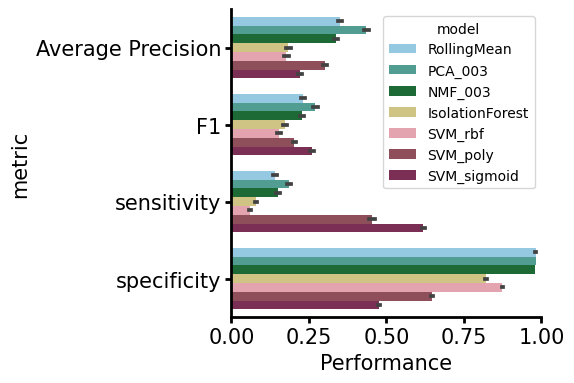

In [9]:
perf_melt = performance_df.melt(
    id_vars=groupby_cols + ['model'],
    value_vars=['Average Precision', 'F1', 'sensitivity', 'specificity'],
    var_name='metric',
    value_name='Performance'
)
perf_melt.loc[perf_melt.model == 'svm', 'model'] = 'SVM'
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(
    y='metric',
    x='Performance',
    hue='model',
    palette=palette['model'],
    hue_order=model_order,
    data=perf_melt,
    ax=ax
)
ax.set_xlim(0,1)
fa.despine_thicken_axes(ax, fontsize=15)

In [10]:
performance_df['anomaly_freq'].unique()

array([ 2,  7, 14, 28])

Average Precision     F1  sensitivity  \
model           history_type                                             
IsolationForest history_0_to_28              0.183  0.163        0.089   
                history_all_28               0.183  0.181        0.072   
NMF_003         history_0_to_28              0.342  0.223        0.146   
                history_all_28               0.330  0.231        0.157   
PCA_003         history_0_to_28              0.416  0.258        0.173   
                history_all_28               0.455  0.282        0.199   
RollingMean     history_0_to_28              0.355  0.229        0.138   
                history_all_28               0.345  0.234        0.141   
SVM_poly        history_0_to_28              0.294  0.211        0.447   
                history_all_28               0.311  0.195        0.461   
SVM_rbf         history_0_to_28              0.176  0.149        0.060   
                history_all_28               0.179  0.159        0.059   
SVM_sigmoid     history_0_to_28              0.213  0.252        0.608   
                history_all_28               0.227  0.266        0.630   

                                 specificity  
model           history_type                  
IsolationForest history_0_to_28        0.794  
                history_all_28         0.847  
NMF_003         history_0_to_28        0.981  
                history_all_28         0.978  
PCA_003         history_0_to_28        0.982  
                history_all_28         0.983  
RollingMean     history_0_to_28        0.982  
                history_all_28         0.980  
SVM_poly        history_0_to_28        0.676  
                history_all_28         0.621  
SVM_rbf         history_0_to_28        0.861  
                history_all_28         0.887  
SVM_sigmoid     history_0_to_28        0.463  
                history_all_28         0.488

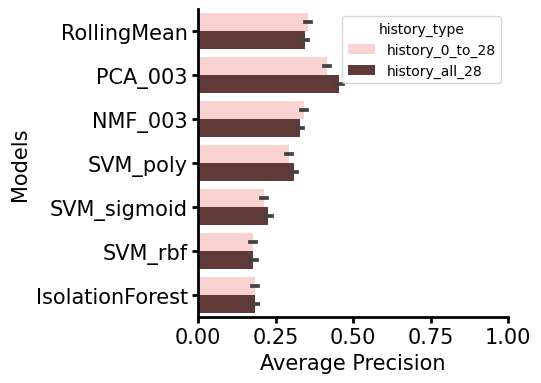

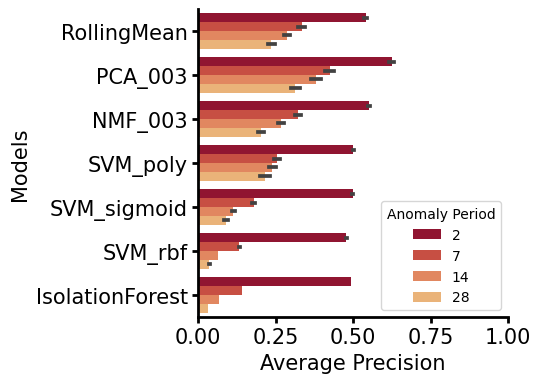

In [12]:
exp = 'exp01'
criteria = (
            (performance_df.experiment == exp)
)
palette['history_type'] = {
    'history_0_to_28': "#FFCCCC",
    'history_all_28': "#663333"
}
performance_df = performance_df.rename(
    columns={'anomaly_freq': 'Anomaly Period'}
)
palette['Anomaly Period'] = {
    2: "#A50026",
    7: "#DD3D2D",
    14: "#F67E4B",
    28: "#FDB366"
}
metric = 'Average Precision'
for i, diff in enumerate(['history_type', 'Anomaly Period']):
    fig, ax = plt.subplots(figsize=(4,4))
    sns.barplot(
        y='model',
        x=metric,
        hue=diff,
        palette=palette[diff],
        data=performance_df[criteria],
        ax=ax
    )
    ax.set_xlim(0,1)
    #ax.legend().remove()
    ax.set_xlabel(metric)
    ax.set_ylabel('Models')
    fa.despine_thicken_axes(ax, fontsize=15)
performance_df[criteria].groupby(['model', 'history_type'])[[metric, 'F1', 'sensitivity', 'specificity']].mean().round(3)

In [19]:
N_SUBJECTS = 100
DAYS_OF_DATA = 120

exp = 'exp02'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp2_df = pd.read_csv(fpath)
exp2_df['experiment'] = exp

In [20]:
exp2_df['n_features'].unique()
anomaly_detector_cols = [d for d in exp2_df.columns if d.endswith("_anomaly")]
anomaly_detector_cont_cols = [d for d in exp2_df.columns if d.endswith("_anomaly_score")]
groupby_cols = [
    'subject_id',
    'window_size',
    'n_features',
    'anomaly_freq',
    'experiment'
]
performance2_df = anomaly_detection.binaryPerformanceMetrics(
    data=exp2_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)
performance2_cont_df = anomaly_detection.continuousPerformanceMetrics(
    data=exp2_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cont_cols,
)
performance2_df = performance2_df.merge(performance2_cont_df.rename(columns={'average_precision': 'Average Precision'}), how='outer')

100%|██████████| 500/500 [00:01<00:00, 322.20it/s]


In [21]:
performance2_df

,subject_id,window_size,n_features,anomaly_freq,experiment,model,true_positives,true_negatives,false_positives,false_negatives,sensitivity,precision,specificity,accuracy,F1,Average Precision
0,SID_0,14,5,28,exp02,RollingMean,3,112,4,1,0.75,0.428571,0.965517,0.958333,0.545455,0.541667
1,SID_0,14,5,28,exp02,PCA_005,1,112,4,3,0.25,0.200000,0.965517,0.941667,0.222222,0.315111
2,SID_0,14,5,28,exp02,NMF_005,2,111,5,2,0.50,0.285714,0.956897,0.941667,0.363636,0.206616
3,SID_0,14,5,28,exp02,SVM_poly,3,67,49,1,0.75,0.057692,0.577586,0.583333,0.107143,0.758333
4,SID_0,14,5,28,exp02,SVM_sigmoid,4,56,60,0,1.00,0.062500,0.482759,0.500000,0.117647,0.266949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,SID_99,14,100,28,exp02,PCA_005,4,107,9,0,1.00,0.307692,0.922414,0.925000,0.470588,0.887500
2996,SID_99,14,100,28,exp02,NMF_005,3,111,5,1,0.75,0.375000,0.956897,0.950000,0.500000,0.423052
2997,SID_99,14,100,28,exp02,SVM_poly,2,78,38,2,0.50,0.050000,0.672414,0.666667,0.090909,0.150000
2998,SID_99,14,100,28,exp02,SVM_sigmoid,4,28,88,0,1.00,0.043478,0.241379,0.266667,0.083333,0.377381


F1  sensitivity  specificity
model       n_features                                 
NMF_005     5           0.314        0.318        0.963
            10          0.392        0.400        0.967
            25          0.490        0.588        0.968
            50          0.561        0.742        0.968
            100         0.666        0.880        0.972
PCA_005     5           0.270        0.230        0.960
            10          0.491        0.572        0.973
            25          0.695        0.878        0.976
            50          0.669        0.920        0.969
            100         0.665        0.958        0.967
RollingMean 5           0.338        0.300        0.965
            10          0.395        0.392        0.970
            25          0.528        0.612        0.974
            50          0.626        0.755        0.977
            100         0.771        0.935        0.982
SVM_poly    5           0.101        0.710        0.571
            10          0.114        0.810        0.570
            25          0.125        0.865        0.584
            50          0.131        0.848        0.614
            100         0.144        0.908        0.629
SVM_rbf     5           0.142        0.015        0.906
            10            NaN        0.000        0.967
            25            NaN        0.000        0.998
            50            NaN        0.000        0.999
            100         0.400        0.002        0.999
SVM_sigmoid 5           0.085        0.715        0.478
            10          0.094        0.885        0.411
            25          0.092        0.982        0.328
            50          0.085        1.000        0.258
            100         0.079        1.000        0.199

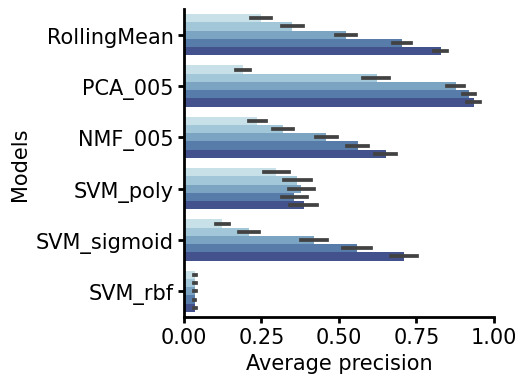

In [22]:
fig, ax = plt.subplots(figsize=(4,4))
subset = performance2_df[
    (performance2_df.window_size == 14) &
    (performance2_df.anomaly_freq == 28)
]
palette['n_features'] = {
    5: "#C2E4EF",
    10: "#98CAE1",
    25: "#6EA6CD",
    50: "#4a7BB7",
    100: "#364B9A",
}
metric = 'Average Precision'
diff = 'n_features'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=subset,
    ax=ax
)
ax.set_xlim(0,1)
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
ax.legend().remove()
fa.despine_thicken_axes(ax, fontsize=15)
subset.groupby(['model', diff])[['F1', 'sensitivity', 'specificity']].mean().round(3)

In [19]:
subset[subset.model == 'SVM_rbf']

,subject_id,window_size,n_features,anomaly_freq,experiment,model,true_positives,true_negatives,false_positives,false_negatives,sensitivity,precision,specificity,accuracy,F1
143,SID_0,14,5,28,exp02,SVM_rbf,0,76,11,3,0.000000,0.000000,0.873563,0.844444,NaN
167,SID_0,14,10,28,exp02,SVM_rbf,0,84,3,3,0.000000,0.000000,0.965517,0.933333,NaN
191,SID_0,14,25,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN
215,SID_0,14,100,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN
239,SID_0,14,200,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35783,SID_99,14,5,28,exp02,SVM_rbf,1,81,6,2,0.333333,0.142857,0.931034,0.911111,0.2
35807,SID_99,14,10,28,exp02,SVM_rbf,0,83,4,3,0.000000,0.000000,0.954023,0.922222,NaN
35831,SID_99,14,25,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN
35855,SID_99,14,100,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN


In [23]:
N_SUBJECTS = 100
DAYS_OF_DATA = 120

exp = 'exp03'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp3_df = pd.read_csv(fpath)
exp3_df['experiment'] = exp


In [24]:
anomaly_detector_cols = [d for d in exp3_df.columns if d.endswith("_anomaly")]
anomaly_detector_cont_cols = [d for d in exp3_df.columns if d.endswith("_anomaly_score")]
groupby_cols = [
    'subject_id',
    'window_size',
    'correlation_type',
    'n_features',
    'anomaly_freq',
    'experiment'
]
performance3_df = anomaly_detection.binaryPerformanceMetrics(
    data=exp3_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)
performance3_cont_df = anomaly_detection.continuousPerformanceMetrics(
    data=exp3_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cont_cols,
)
performance3_df = performance3_df.merge(performance3_cont_df.rename(columns={'average_precision': 'Average Precision'}), how='outer')

100%|██████████| 300/300 [00:00<00:00, 324.30it/s]


Average Precision     F1  sensitivity  \
model       correlation_type                                          
NMF_005     Independent                   0.459  0.484        0.590   
            Linear                        0.330  0.390        0.405   
            Non-linear                    0.314  0.382        0.385   
PCA_005     Independent                   0.867  0.677        0.855   
            Linear                        0.531  0.436        0.485   
            Non-linear                    0.560  0.463        0.560   
RollingMean Independent                   0.510  0.512        0.590   
            Linear                        0.307  0.343        0.332   
            Non-linear                    0.374  0.343        0.400   
SVM_poly    Independent                   0.371  0.123        0.842   
            Linear                        0.320  0.114        0.710   
            Non-linear                    0.205  0.105        0.788   
SVM_rbf     Independent                   0.034    NaN        0.000   
            Linear                        0.036  0.222        0.002   
            Non-linear                    0.035  0.164        0.008   
SVM_sigmoid Independent                   0.410  0.093        0.985   
            Linear                        0.110  0.087        0.752   
            Non-linear                    0.159  0.091        0.875   

                              specificity  
model       correlation_type               
NMF_005     Independent             0.969  
            Linear                  0.968  
            Non-linear              0.967  
PCA_005     Independent             0.976  
            Linear                  0.968  
            Non-linear              0.966  
RollingMean Independent             0.974  
            Linear                  0.963  
            Non-linear              0.960  
SVM_poly    Independent             0.587  
            Linear                  0.624  
            Non-linear              0.539  
SVM_rbf     Independent             0.997  
            Linear                  0.960  
            Non-linear              0.926  
SVM_sigmoid Independent             0.332  
            Linear                  0.449  
            Non-linear              0.397

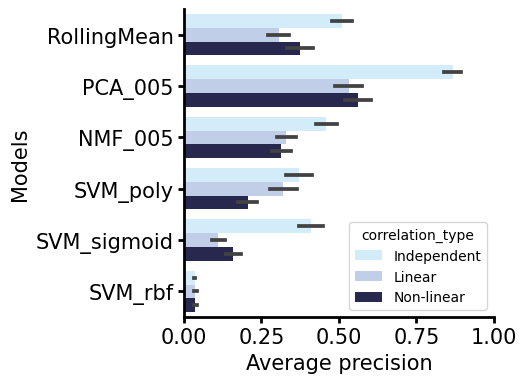

In [25]:
fig, ax = plt.subplots(figsize=(4,4))
palette['correlation_type'] = {
    'Independent': "#CCEEFF", 
    'Linear': "#BBCCEE", 
    'Non-linear': "#222255"
}
metric = 'Average Precision'
diff = 'correlation_type'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=performance3_df,
    ax=ax
)
ax.set_xlim(0,1)
#ax.legend().remove()
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
fa.despine_thicken_axes(ax, fontsize=15)
performance3_df.groupby(['model', diff])[['Average Precision', 'F1', 'sensitivity', 'specificity']].mean().round(3)

In [26]:
N_SUBJECTS = 100
DAYS_OF_DATA = 120

exp = 'exp07'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp7_df = pd.read_csv(fpath)
exp7_df['experiment'] = exp


In [27]:

groupby_cols = [
    'subject_id',
    'window_size',
    'n_features',
    'anomaly_freq',
    'history_type',
    'experiment'
]
anomaly_detector_cols = [d for d in exp7_df.columns if d.endswith("_anomaly")]
anomaly_detector_cont_cols = [d for d in exp7_df.columns if d.endswith("_anomaly_score")]
performance7_df = anomaly_detection.binaryPerformanceMetrics(
    data=exp7_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)
performance7_cont_df = anomaly_detection.continuousPerformanceMetrics(
    data=exp7_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cont_cols,
)
performance7_df = performance7_df.merge(performance7_cont_df.rename(columns={'average_precision': 'Average Precision'}), how='outer')

100%|██████████| 600/600 [00:01<00:00, 316.30it/s]


In [28]:
performance7_df

,subject_id,window_size,n_features,anomaly_freq,history_type,experiment,model,true_positives,true_negatives,false_positives,false_negatives,sensitivity,precision,specificity,accuracy,F1,Average Precision
0,SID_0,14,5,28,history_all_28,exp07,RollingMean,3,112,4,1,0.75,0.428571,0.965517,0.958333,0.545455,0.541667
1,SID_0,14,5,28,history_all_28,exp07,PCA_005,1,112,4,3,0.25,0.200000,0.965517,0.941667,0.222222,0.315111
2,SID_0,14,5,28,history_all_28,exp07,NMF_005,2,111,5,2,0.50,0.285714,0.956897,0.941667,0.363636,0.206616
3,SID_0,14,5,28,history_all_28,exp07,SVM_poly,3,67,49,1,0.75,0.057692,0.577586,0.583333,0.107143,0.758333
4,SID_0,14,5,28,history_all_28,exp07,SVM_sigmoid,4,56,60,0,1.00,0.062500,0.482759,0.500000,0.117647,0.266949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,SID_99,14,500,28,history_all_28,exp07,PCA_005,0,111,5,4,0.00,0.000000,0.956897,0.925000,NaN,0.097381
3596,SID_99,14,500,28,history_all_28,exp07,NMF_005,1,113,3,3,0.25,0.250000,0.974138,0.950000,0.250000,0.175350
3597,SID_99,14,500,28,history_all_28,exp07,SVM_poly,4,66,50,0,1.00,0.074074,0.568966,0.583333,0.137931,0.033333
3598,SID_99,14,500,28,history_all_28,exp07,SVM_sigmoid,4,17,99,0,1.00,0.038835,0.146552,0.175000,0.074766,0.031098


Average Precision     F1  sensitivity  specificity
model       n_features                                                    
NMF_005     5                       0.237  0.314        0.318        0.963
            10                      0.091  0.229        0.105        0.957
            25                      0.085  0.254        0.060        0.962
            50                      0.083  0.258        0.050        0.968
            100                     0.089  0.268        0.060        0.969
            500                     0.088  0.259        0.062        0.969
PCA_005     5                       0.190  0.270        0.230        0.960
            10                      0.085  0.234        0.065        0.955
            25                      0.087  0.279        0.058        0.968
            50                      0.079  0.228        0.042        0.964
            100                     0.079  0.221        0.052        0.960
            500                     0.084  0.228        0.082        0.952
RollingMean 5                       0.248  0.338        0.300        0.965
            10                      0.088  0.216        0.072        0.956
            25                      0.081  0.256        0.062        0.966
            50                      0.085  0.275        0.055        0.972
            100                     0.084  0.304        0.040        0.973
            500                     0.076  0.280        0.022        0.978
SVM_poly    5                       0.298  0.101        0.710        0.571
            10                      0.083  0.076        0.550        0.546
            25                      0.063  0.073        0.525        0.533
            50                      0.048  0.082        0.575        0.551
            100                     0.055  0.081        0.580        0.551
            500                     0.053  0.077        0.598        0.511
SVM_rbf     5                       0.035  0.142        0.015        0.906
            10                      0.047  0.150        0.085        0.908
            25                      0.054  0.400        0.002        0.994
            50                      0.059    NaN        0.000        0.999
            100                     0.056    NaN        0.000        0.999
            500                     0.053  0.400        0.002        0.999
SVM_sigmoid 5                       0.123  0.085        0.715        0.478
            10                      0.044  0.077        0.620        0.475
            25                      0.046  0.077        0.830        0.322
            50                      0.051  0.075        0.902        0.234
            100                     0.043  0.074        0.962        0.170
            500                     0.048  0.074        0.998        0.135

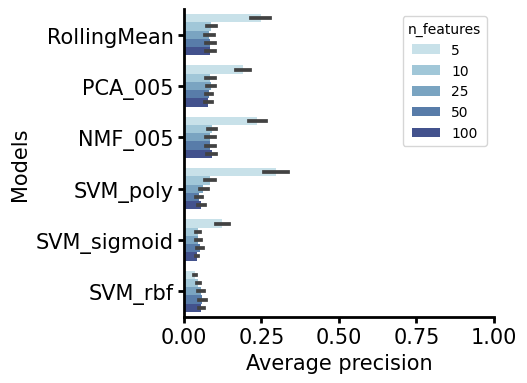

In [29]:

fig, ax = plt.subplots(figsize=(4,4))
palette['n_features'] = {
    5: "#C2E4EF",
    10: "#98CAE1",
    25: "#6EA6CD",
    50: "#4a7BB7",
    100: "#364B9A",
}
metric = 'Average Precision'
diff = 'n_features'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=performance7_df[performance7_df.n_features < 500],
    ax=ax
)
ax.set_xlim(0,1)
#ax.legend().remove()
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
fa.despine_thicken_axes(ax, fontsize=15)
performance7_df.groupby(['model', diff])[['Average Precision', 'F1', 'sensitivity', 'specificity']].mean().round(3)